<a href="https://colab.research.google.com/github/rihat99/openai_gym/blob/main/BipedalWalker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

!pip install box2d-py
import gym

env = gym.make("BipedalWalker-v3")

# tf.random.set_seed(42)
# np.random.seed(42)
# env.seed(42)
print(tf.__version__)
print(gym.__version__)

     |████████████████████████████████| 450kB 14.9MB/s 
2.4.1
0.17.3


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [2]:
num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))
#num_actions = 3

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  24
Size of Action Space ->  4
Max Value of Action ->  1.0
Min Value of Action ->  -1.0


In [3]:
layer_size = 512

def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    #last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states))
    out = layers.Dense(layer_size, activation="elu")(inputs)
    out = layers.Dense(layer_size, activation="elu")(out)
    outputs = layers.Dense(num_actions, activation="tanh")(out)

    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(layer_size//2, activation="elu")(state_input)
    state_out = layers.Dense(layer_size, activation="elu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(layer_size//2, activation="elu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(layer_size, activation="elu")(concat)
    out = layers.Dense(layer_size//2, activation="elu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

In [17]:
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.done_buffer = np.zeros((self.buffer_capacity, 1))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]
        self.done_buffer[index] = obs_tuple[4]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch, done_batch
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        target_actions = target_actor(next_state_batch, training=True)
        noise = tf.random.normal(mean=0.0, stddev=std_dev_target, 
                                 shape=(self.batch_size, num_actions), dtype=tf.float32)
        noise = tf.clip_by_value(noise, -noise_clip, noise_clip)
        target_actions = target_actions + noise
        target_actions = tf.clip_by_value(target_actions, 
                                            lower_bound, upper_bound)

        Q_values_a = target_critic_a([next_state_batch, target_actions], training=True)
        Q_values_b = target_critic_b([next_state_batch, target_actions], training=True)
        min_Q_values = tf.math.minimum(Q_values_a, Q_values_b)

        y = reward_batch + (1-done_batch) * gamma * min_Q_values

        with tf.GradientTape() as tape:
            critic_value_a = critic_model_a([state_batch, action_batch], training=True)
            critic_loss_a = tf.math.reduce_mean(tf.math.square(y - critic_value_a))

        critic_grad_a = tape.gradient(critic_loss_a, critic_model_a.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad_a, critic_model_a.trainable_variables)
        )

        with tf.GradientTape() as tape:
            critic_value_b = critic_model_b([state_batch, action_batch], training=True)
            critic_loss_b = tf.math.reduce_mean(tf.math.square(y - critic_value_b))

        critic_grad_b = tape.gradient(critic_loss_b, critic_model_b.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad_b, critic_model_b.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value_a = critic_model_a([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.reduce_mean(critic_value_a)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables))

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])
        done_batch = tf.convert_to_tensor(self.done_buffer[batch_indices])
        done_batch = tf.cast(done_batch, dtype=tf.float32)

        self.update(state_batch, action_batch, reward_batch, next_state_batch, done_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

In [5]:
def policy(state, noise = 0, epsilon = 0):
    if np.random.rand() < epsilon:
        return np.random.rand(num_actions)
    else:
        sampled_actions = actor_model(state)[0]
        sampled_actions = sampled_actions.numpy() + noise
        legal_action = np.clip(sampled_actions, lower_bound, upper_bound)
        return legal_action

In [18]:
std_dev_target = 0.2
noise_clip = 0.4
std_dev_action = 0.1

actor_model = get_actor()
critic_model_a = get_critic()
critic_model_b = get_critic()

target_actor = get_actor()
target_critic_a = get_critic()
target_critic_b = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic_a.set_weights(critic_model_a.get_weights())
target_critic_b.set_weights(critic_model_b.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.0003
actor_lr = 0.0003

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 1000
# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.005

epsilon = 0.1
update_rate = 2

buffer = Buffer(100000, 64)

from IPython.display import clear_output
ep_reward_list = []
avg_reward_list = []
best_score = -200
best_weights = actor_model.get_weights()

Episode: 549 Current Reward: 303.5315072555169
Average_reward:  187.25732337149748
Steps:  766


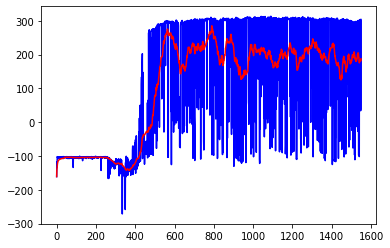

KeyboardInterrupt: ignored

In [20]:
for ep in range(total_episodes):

    prev_state = env.reset()
    episodic_reward = 0
    step = 0
    noise_list = np.random.normal(loc=0.0, scale=std_dev_action, size=1600)
    noise_list = np.clip(noise_list, -noise_clip, noise_clip)

    while True:

        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

        action = policy(tf_prev_state, noise_list[step%1600], epsilon)
        state, reward, done, info = env.step(action)

        buffer.record((prev_state, action, reward, state, done))
        episodic_reward += reward
        if step % (update_rate * 2) == 0:
            update_target(target_actor.variables, actor_model.variables, tau)
        if step % update_rate == 0:
            buffer.learn()
            buffer.learn()
            update_target(target_critic_a.variables, critic_model_a.variables, tau)
            update_target(target_critic_b.variables, critic_model_b.variables, tau)

        if done:
            break

        prev_state = state
        step += 1

    ep_reward_list.append(episodic_reward)
    avg_reward = np.mean(ep_reward_list[-40:])
    avg_reward_list.append(avg_reward)
    clear_output(wait=True)
    print('Episode:', ep, 'Current Reward:', episodic_reward)
    print('Average_reward: ', avg_reward)
    print('Steps: ', step)
    if avg_reward > best_score:
        best_weights = actor_model.get_weights()
        best_score = avg_reward
    plt.plot(np.arange(len(ep_reward_list)),ep_reward_list, 'b',
             np.arange(len(avg_reward_list)), avg_reward_list, 'r')
    plt.show()
    

In [21]:
best_actor = keras.models.clone_model(actor_model)
print(best_score)
best_actor.set_weights(best_weights)
best_actor.save("BipedalWalker")

285.0141734013132
INFO:tensorflow:Assets written to: BipedalWalker/assets


In [31]:
reconstructed_model = keras.models.load_model('BipedalWalker')

def smart_policy(obs):
    action_prob = reconstructed_model(obs[np.newaxis])
    legal_action = np.clip(action_prob[0], lower_bound, upper_bound)
    return legal_action

totals = []
for episode in range(100):
    episode_reward = 0
    obs = env.reset()
    while True:
        action = smart_policy(obs)
        obs, reward, done, info = env.step(action)
        #env.render()
        episode_reward += reward
        if done:
            break
    totals.append(episode_reward)

env.close()

import numpy as np
print(np.mean(totals), np.std(totals), np.min(totals), np.max(totals))
#print(totals)

306.3647997859273 0.5477522393275229 304.90536810700604 307.6689695618839


In [ ]:
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install -U colabgymrender

from colabgymrender.recorder import Recorder

directory = './video'
video_env = Recorder(env, directory)

In [28]:
obs = video_env.reset()
while True:
    action = best_actor(obs[np.newaxis])[0]
    obs, reward, done, info = video_env.step(action)
    if done:
        break

In [29]:
video_env.play()

100%|██████████| 822/822 [00:02<00:00, 377.08it/s]
